In [69]:
import pandas as pd
from pathlib import Path
import dotenv
import seaborn as sns

In [70]:
benchmark_folder = Path(dotenv.find_dotenv()).parent
results_folder = benchmark_folder.joinpath("results")

In [71]:
time_cpu = pd.read_csv(results_folder.joinpath("benchmark_results_cpu.tsv"), sep="\t", index_col=0)
mem_cpu = pd.read_csv(results_folder.joinpath("memory_cpu.csv"), sep=",")
mem_cpu["device"] = "CPU"
time_cpu = time_cpu.merge(mem_cpu, how="left")
time_cpu

,command,mean,stddev,median,user,system,min,max,map_size,device,max_memory_cpu
0,drexml run --no-add disease.env,756.088634,2.099031,755.572526,11070.151766,725.128525,753.675460,759.318303,1,CPU,9.86 G
1,drexml run --no-add disease.env,5015.780697,28.543543,5009.626727,125638.230340,2058.720919,4985.324824,5061.486136,25,CPU,17.10 G
2,drexml run --no-add disease.env,11384.616875,63.463035,11373.451941,303602.933561,3445.282582,11265.592371,11487.687918,50,CPU,28.22 G
3,drexml run --no-add disease.env,16514.219318,60.963980,16510.313850,448056.602684,4461.343084,16424.876338,16597.549724,75,CPU,34.57 G
4,drexml run --no-add disease.env,21658.041681,70.049113,21636.453246,596641.058382,5142.740966,21579.261236,21790.251365,100,CPU,38.16 G


In [72]:
time_gpu = pd.read_csv(results_folder.joinpath("benchmark_results_gpu.tsv"), sep="\t", index_col=0)
mem_gpu = pd.read_csv(results_folder.joinpath("memory_gpu.csv"), sep=",")
mem_gpu["device"] = "GPU"
time_gpu = time_gpu.merge(mem_gpu, how="left")
time_gpu

,command,mean,stddev,median,user,system,min,max,map_size,device,max_memory_cpu,max_memory_gpu
0,drexml run --n-gpus 3 --no-add disease.env,799.640462,2.141657,799.807113,11038.003039,378.631615,797.057585,802.302581,1,GPU,6.76 G,0.41 G
1,drexml run --n-gpus 3 --no-add disease.env,3692.538895,8.377342,3692.994991,36117.598852,2086.981972,3680.669390,3707.770052,25,GPU,10.9 G,1.82 G
2,drexml run --n-gpus 3 --no-add disease.env,7456.557072,14.099179,7458.389602,59511.514498,4488.179815,7431.891204,7474.415861,50,GPU,14.18 G,3.91 G
3,drexml run --n-gpus 3 --no-add disease.env,11050.915189,17.461159,11046.718830,85566.151410,6756.182519,11022.509319,11085.778471,75,GPU,16.5 G,4.2 G
4,drexml run --n-gpus 3 --no-add disease.env,14736.681726,19.632199,14733.902063,106680.627516,9168.400271,14703.764340,14772.027297,100,GPU,18.5 G,5.4 G


In [73]:
results = pd.concat([time_cpu, time_gpu], ignore_index=True, axis=0)
results = results.fillna("-")
results.head()

,command,mean,stddev,median,user,system,min,max,map_size,device,max_memory_cpu,max_memory_gpu
0,drexml run --no-add disease.env,756.088634,2.099031,755.572526,11070.151766,725.128525,753.675460,759.318303,1,CPU,9.86 G,-
1,drexml run --no-add disease.env,5015.780697,28.543543,5009.626727,125638.230340,2058.720919,4985.324824,5061.486136,25,CPU,17.10 G,-
2,drexml run --no-add disease.env,11384.616875,63.463035,11373.451941,303602.933561,3445.282582,11265.592371,11487.687918,50,CPU,28.22 G,-
3,drexml run --no-add disease.env,16514.219318,60.963980,16510.313850,448056.602684,4461.343084,16424.876338,16597.549724,75,CPU,34.57 G,-
4,drexml run --no-add disease.env,21658.041681,70.049113,21636.453246,596641.058382,5142.740966,21579.261236,21790.251365,100,CPU,38.16 G,-


In [74]:
import numpy as np
import matplotlib.pyplot as plt

def plot_errorbars(arg, **kws):
    np.random.seed(sum(map(ord, "error_bars")))
    x = np.random.normal(0, 1, 100)
    f, axs = plt.subplots(2, figsize=(7, 2), sharex=True, layout="tight")
    sns.pointplot(x=x, errorbar=arg, **kws, capsize=.3, ax=axs[0])
    sns.stripplot(x=x, jitter=.3, ax=axs[1])

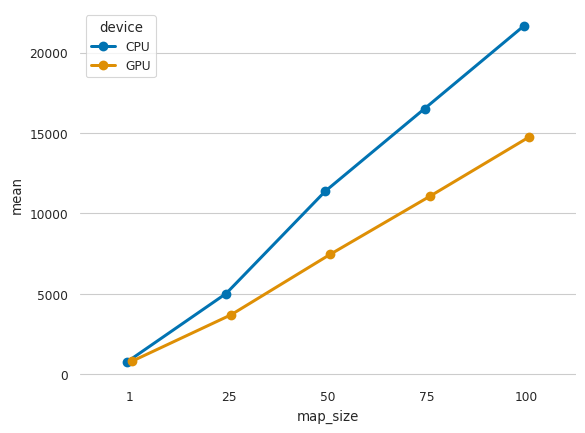

In [75]:
#results.plot(kind='bar', x='map_size', y='mean', yerr='stddev', rot=0, by="device")
ax = sns.pointplot(data=results, x="map_size", dodge=True, hue="device", y="mean",  errorbar=None, linestyle=None)
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

#ax.errorbar(x_coords, y_coords, yerr=errors, ecolor=colors, fmt=' ', zorder=-1)

In [76]:
# hack to use precommputed errors
n_duplicates = 1000
df_tmp = pd.concat([results for _ in range(n_duplicates)], axis=0, ignore_index=True)
df_tmp['y'] = np.random.normal(df_tmp['mean'].values, df_tmp['stddev'].values)

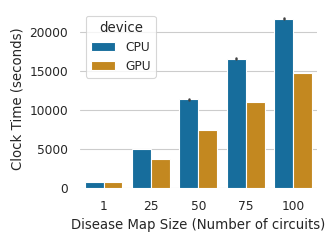

In [77]:
#sns.set(font="monospace")
custom_params = {
            "axes.spines.right": False,
            "axes.spines.top": False,
            "axes.spines.left": False,
            "axes.spines.bottom": False,
        }

sns.set_theme(
            style="whitegrid", palette="colorblind", context="paper", rc=custom_params
        )

fig, ax = plt.subplots(1, 1)
width=2.8

ax = sns.barplot(data=df_tmp, 
                   x="map_size", 
                   dodge=True, 
                   hue="device", y="y",  errorbar="sd", seed=42)
ax.set_xlabel("Disease Map Size (Number of circuits)")
ax.set_ylabel("Clock Time (seconds)")

fname = "time_benchmark"
fig.tight_layout()
fig.set_size_inches(width, (width * 3) / 4)
plt.savefig(
    results_folder.joinpath(f"{fname}.png"), dpi=300, bbox_inches="tight"
)
plt.savefig(results_folder.joinpath(f"{fname}.pdf"), bbox_inches="tight")

In [78]:
x = (
    results[["device", "map_size", "mean", "stddev", "max_memory_cpu", "max_memory_gpu"]]
    .rename(columns={"map_size": "Map size", 
                     "device": "Device",
                     })
).pivot(index="Map size", columns="Device")

caption_str = r"""Memory (in GB)  and clock time benchmarking results (in seconds) for the \texttt{drexml} 
    package on varying disease map sizes (number of circuits) and hardware 
    configurations (CPU/GPU).
"""

(
    x
    .style
    .format(precision=2)
    .format_index("\\textbf{{{}}}", escape="latex", axis=1)
    .to_latex(
        results_folder.joinpath(f"{fname}_withmem.tex"),
        column_format="r",
        multicol_align="c",
        multirow_align="l",
        clines="skip-last;data",
        hrules=True, 
        label="tab:time", 
        position_float="centering",
        caption=caption_str)
)